## Image Extraction in Habitat Sim

author: Michael Piseno (mpiseno@gatech.edu)

This notebook will go over how to use the Image Extraction API in Habitat Sim and the different user options available.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from habitat_sim.utils.data.dataextractor import ImageExtractor

### Setting up the Extractor

The main class that handles image data extraction in Habitat Sim is called ImageExtractor. The user needs to provide a scene filepath (either a .glb or .ply file) to the constructor. This is the only required constructor argument.

In [2]:
# Replace this with whatever scene filepath you want
scene_filepath = "/Users/mpiseno/Documents/Habitat/habitat_mpiseno/habitat-sim/data/scene_datasets/habitat-test-scenes/skokloster-castle.glb"
extractor = ImageExtractor(scene_filepath)
extractor.close()

I0211 17:03:27.314789 16951 simulator.py:142] Loaded navmesh /Users/mpiseno/Documents/Habitat/habitat_mpiseno/habitat-sim/data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh


Habitat Sim does not currently support multiple instances or extractors, so if you're done using an extractor you need to call the close method before instantiating a new one. Below we will go over some optional arguments for the extractor class.

* scene_filepath: The filepath to the scene file as explained above
* labels: Class labels of the type of images the user wants to extract. Currently we only support extracting images of 'unnavigable points' like walls. In the future we hope to extend this functionality to allow the user to specify more unique class labels, but for now this argument is not that useful.
* img_size: The size of images to be output in the format (height, width)
* output: A list of the different output image types the user can obtain. Default is rgba.

In [3]:
try:
    extractor.close()
except:
    pass

extractor = ImageExtractor(scene_filepath, labels=[0.0], img_size=(512, 512), output=['rgba', 'depth', 'semantic'])

I0211 17:03:49.564811 16951 simulator.py:142] Loaded navmesh /Users/mpiseno/Documents/Habitat/habitat_mpiseno/habitat-sim/data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh


### Using the Extractor

#### Indexing and Slicing

The extractor can be indexed and sliced like a normal python list. Internaly, indexing into the extractor sets an agent position and rotation within the simulator and returns the corresponding agent observation. Indexing returns a dictionary that contains an image of each type specified in the "output" argument given by the user in the constructor. The dictionary also contains a key "label" which is the class label (specified by the user in the constructor) of the image. Note: for the scene in this example there is no semantic data which is why the semantic output below is not represented.

Indexing



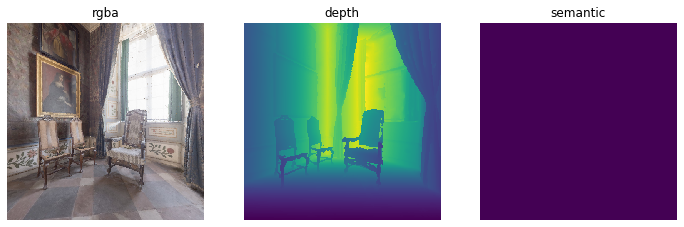


Slicing



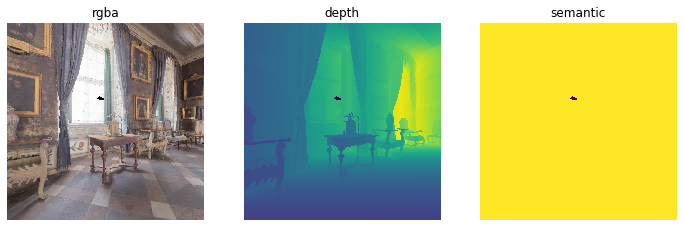

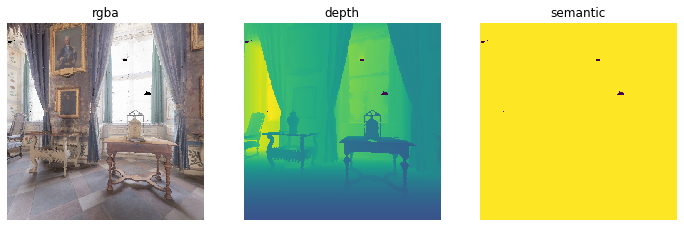

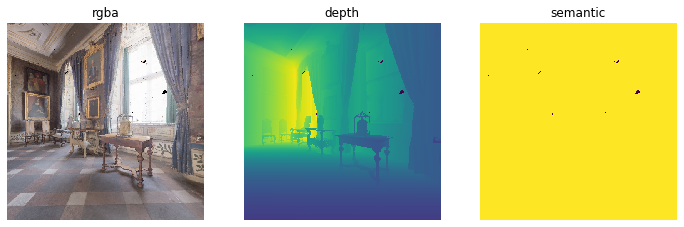

In [4]:
def display_sample(sample):
    img = sample['rgba']
    depth = sample['depth']
    semantic = sample['semantic']
    label = sample['label']

    arr = [img, depth, semantic]
    titles = ['rgba', 'depth', 'semantic']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    
    plt.show()
    
# Indexing
print("Indexing\n")
sample = extractor[0]
display_sample(sample)

# Slicing
print("\nSlicing\n")
samples = extractor[1:4]
for sample in samples:
    display_sample(sample)

#### Integrating with PyTorch Datasets

It is very easy to plug an ImageExtractor into a PyTorch Datasets and DataLoaders for end to end training in PyTorch models without writing to disk. For a great tutorial on how to use PyTorch Dataset and DataLoader, refer to [this guide](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class HabitatDataset(Dataset):
    def __init__(self, extractor):
        self.extractor = extractor
    
    def __len__(self):
        return len(self.extractor)
    
    def __getitem__(self, idx):
        sample = self.extractor[idx]
        output = {
            'rgba': sample['rgba'].astype(np.float32), # dataloader requires certain types
            'label': sample['label']
        }
        return output


class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 8, 10, 10)
        self.fc1 = nn.Linear(20808, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.view(-1, self.get_flat_dim(x))
        x = self.fc1(x)
        return x
    
    def get_flat_dim(self, x):
        dim_size = 1
        for dim in x.size()[1:]:
            dim_size *= dim
        
        return dim_size
    
dataset = HabitatDataset(extractor)
dataloader = DataLoader(dataset, batch_size=2)
net = TrivialNet()

for i, sample_batch in enumerate(dataloader):
    img, label = sample_batch['rgba'], sample_batch['label']
    img = img.permute(0, 3, 1, 2) # Reshape to PyTorch format for convolutions
    out = net(img)

### Appendix

In this section I'll explain briefly how the image extraction is actually done so that others can make changes if necessary. When the user creates a ImageExtractor, the following sequence of events happen:

1. A Simulator class is created and a 2D topdown view of the scene is generated
2. Using the topdown view, the PoseExtractor class creates a grid of points spaced equally across the topdown view
3. For each grid point, the PoseExtractor uses breadth-first search to find the closest 'point of interest'. A point of interest is a point specified by the class labels argument to ImageExtractor.
4. The PoseExtractor returns a list of poses, where each pose contains (position, rotation, label) information. When it comes time for the ImageExtractor to return an image to the user, these poses are used to set the agent state within the simulator.

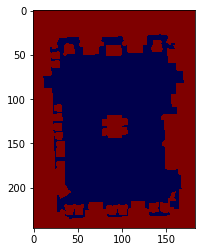

In [7]:
extractor.pose_extractor._show_topdown_view()